# Comparing datasets over California

Within the state of California we can compare our risk estimates with estimates from two other datasets: (1) the Wildfire Risk to Communities project (as in the other comparison notebook attached to this project) and the [California Fire Hazard Severity Zones](https://osfm.fire.ca.gov/what-we-do/community-wildfire-preparedness-and-mitigation/fire-hazard-severity-zones). This notebook contains those comparisons.

In [1]:
from itertools import combinations

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import odc.geo.xr  # noqa
import pandas as pd
import xarray as xr
from scipy.stats import kendalltau

from ocr import catalog

In [2]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
ca = states[states['STUSPS'].isin(['CA'])]

census_tracts_df = (
    catalog.get_dataset('us-census-tracts')
    .query_geoparquet(
        "SELECT GEOID, NAME, ST_AsText(geometry) as geometry, bbox FROM read_parquet('{s3_path}')"
    )
    .df()
)
census_tracts = gpd.GeoDataFrame(
    census_tracts_df, geometry=gpd.GeoSeries.from_wkt(census_tracts_df['geometry'])
)

ca_census_tracts = census_tracts.loc[census_tracts.geometry.intersects(ca.unary_union)]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_6577/1896281089.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ca_census_tracts = census_tracts.loc[census_tracts.geometry.intersects(ca.unary_union)]


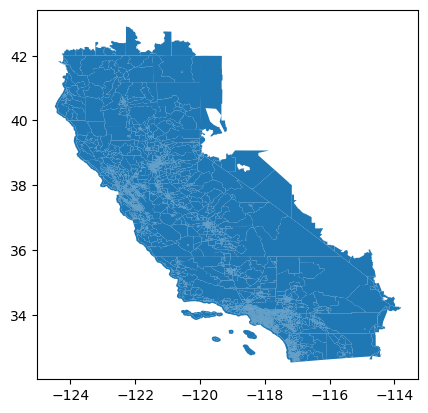

In [3]:
ca_census_tracts.plot();

In [4]:
import duckdb

duckdb.sql("""INSTALL SPATIAL; LOAD SPATIAL; INSTALL HTTPFS; LOAD HTTPFS""")

version = 'v0.12.0'
dataset_uri = f's3://carbonplan-ocr/output/fire-risk/vector/production/{version}/geoparquet/buildings.parquet/**'

CA_FIPS_CODE = '06'

In [5]:
%%time

df = duckdb.sql(f"""
SELECT
    * EXCLUDE (geometry),
    ST_AsText(geometry) as geometry
FROM
   read_parquet('{dataset_uri}', hive_partitioning = TRUE)
WHERE
   state_fips = '{CA_FIPS_CODE}'
""").df()

gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))
gdf.head()

CPU times: user 1min 45s, sys: 8.51 s, total: 1min 53s
Wall time: 1min 10s


,USFS_RPS,wind_risk_2011,wind_risk_2047,burn_probability_2011,burn_probability_2047,conditional_risk_usfs,burn_probability_usfs_2011,burn_probability_usfs_2047,GEOID,state,county,bbox,county_fips,state_fips,geometry
0,2.145266,2.178693,2.545082,0.040383,0.047174,53.951012,0.0408,0.04745,060014511043112,CA,Alameda County,"{'xmin': -121.5374613, 'ymin': 37.4933285, 'xm...",001,06,"POLYGON ((-121.53746 37.49337, -121.53727 37.4..."
1,2.145266,2.178693,2.545082,0.040383,0.047174,53.951012,0.0408,0.04745,060014511043112,CA,Alameda County,"{'xmin': -121.5372578, 'ymin': 37.4935059, 'xm...",001,06,"POLYGON ((-121.53708 37.49368, -121.5372 37.49..."
2,1.602233,1.650245,1.977764,0.029983,0.035934,55.039391,0.0307,0.03655,060014511043109,CA,Alameda County,"{'xmin': -121.5324932, 'ymin': 37.5265686, 'xm...",001,06,"POLYGON ((-121.53242 37.52657, -121.53238 37.5..."
3,1.538241,1.644779,1.938649,0.030116,0.035497,54.614368,0.0307,0.03655,060014511043109,CA,Alameda County,"{'xmin': -121.5317404, 'ymin': 37.5281865, 'xm...",001,06,"POLYGON ((-121.53165 37.52822, -121.53172 37.5..."
4,0.751235,0.806083,0.947878,0.029008,0.034110,27.788677,0.0303,0.03470,060014511043109,CA,Alameda County,"{'xmin': -121.52894, 'ymin': 37.527909, 'xmax'...",001,06,"POLYGON ((-121.52888 37.52791, -121.52888 37.5..."


In [6]:
ca_buildings = gdf.loc[gdf.geometry.intersects(ca.union_all())]
ca_buildings.shape, gdf.shape

((13686719, 15), (13711723, 15))

In [7]:
%%time
ds_reprojected = catalog.get_dataset('calfire-fhsz-4326').to_xarray()

# get building coords
# coords = [(geom.x, geom.y) for geom in ca_buildings.geometry.centroid]
# coords = np.array(coords)
coords = np.column_stack([ca_buildings.geometry.centroid.x, ca_buildings.geometry.centroid.y])

# extract hazard for buildings
building_hazard = ds_reprojected.sel(
    latitude=xr.DataArray(coords[:, 1], dims='building'),
    longitude=xr.DataArray(coords[:, 0], dims='building'),
    method='nearest',
)
building_hazard

CPU times: user 16.3 s, sys: 1.17 s, total: 17.5 s
Wall time: 17.6 s


<xarray.Dataset> Size: 274MB
Dimensions:      (band: 1, building: 13686719)
Coordinates:
  * band         (band) int64 8B 1
    longitude    (building) float64 109MB -121.5 -121.5 -121.5 ... -121.3 -121.3
    latitude     (building) float64 109MB 37.49 37.49 37.53 ... 39.33 39.33
Dimensions without coordinates: building
Data variables:
    band_data    (band, building) float32 55MB dask.array<chunksize=(1, 13686719), meta=np.ndarray>
    spatial_ref  int32 4B ...
Attributes:
    title:        California Fire Hazard Severity Zones (FHSZ)
    version:      
    data_source:  
    description:  California Fire Hazard Severity Zones (FHSZ) dataset from C...
    EPSG:         4326

In [8]:
%%time
# cast all nulls to zeros. areas with zero are considered without hazard in the cal fire approach
# and by casting them to zero we make them have a lower value than the non-zero values which
# prepares the data for a ranked test like kendall-tau
building_hazard = xr.where(building_hazard.band_data.isnull(), 0, building_hazard.band_data)
ca_buildings['cal-fire-hazard-zone'] = building_hazard.values[0]

ca_buildings_in_census_tracts = gpd.sjoin(ca_buildings, ca_census_tracts[['GEOID', 'geometry']])
ca_buildings_in_census_tracts.head()

/opt/coiled/env/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


CPU times: user 4min 7s, sys: 1.82 s, total: 4min 9s
Wall time: 4min 7s


,USFS_RPS,wind_risk_2011,wind_risk_2047,burn_probability_2011,burn_probability_2047,conditional_risk_usfs,burn_probability_usfs_2011,burn_probability_usfs_2047,GEOID_left,state,county,bbox,county_fips,state_fips,geometry,cal-fire-hazard-zone,index_right,GEOID_right
0,2.145266,2.178693,2.545082,0.040383,0.047174,53.951012,0.0408,0.04745,060014511043112,CA,Alameda County,"{'xmin': -121.5374613, 'ymin': 37.4933285, 'xm...",001,06,"POLYGON ((-121.53746 37.49337, -121.53727 37.4...",0.0,4289,06001451104
1,2.145266,2.178693,2.545082,0.040383,0.047174,53.951012,0.0408,0.04745,060014511043112,CA,Alameda County,"{'xmin': -121.5372578, 'ymin': 37.4935059, 'xm...",001,06,"POLYGON ((-121.53708 37.49368, -121.5372 37.49...",0.0,4289,06001451104
2,1.602233,1.650245,1.977764,0.029983,0.035934,55.039391,0.0307,0.03655,060014511043109,CA,Alameda County,"{'xmin': -121.5324932, 'ymin': 37.5265686, 'xm...",001,06,"POLYGON ((-121.53242 37.52657, -121.53238 37.5...",0.0,4289,06001451104
3,1.538241,1.644779,1.938649,0.030116,0.035497,54.614368,0.0307,0.03655,060014511043109,CA,Alameda County,"{'xmin': -121.5317404, 'ymin': 37.5281865, 'xm...",001,06,"POLYGON ((-121.53165 37.52822, -121.53172 37.5...",0.0,4289,06001451104
3,1.538241,1.644779,1.938649,0.030116,0.035497,54.614368,0.0307,0.03655,060014511043109,CA,Alameda County,"{'xmin': -121.5317404, 'ymin': 37.5281865, 'xm...",001,06,"POLYGON ((-121.53165 37.52822, -121.53172 37.5...",0.0,12591,06077005502


In [9]:
%%time
path = f's3://carbonplan-ocr/evaluation/comparisons/buildings-tracts-california-{version}.parquet'
ca_buildings_in_census_tracts.to_parquet(path)

CPU times: user 29.5 s, sys: 2.79 s, total: 32.3 s
Wall time: 32.1 s


## Load in CAL FIRE hazard layer

Note: The CAL FIRE hazard data is very clear that they do not estimate risk, which assesses the level of damage that a fire could cause. The main statistic we use in this analysis is a rank test called the Kendall's Tau which tests for concordance of data, asking: how similarly do two datasets rank areas on a scale from low to high? In other words, given two locations, do the two datsets agree which is higher or lower on a given scale. To do this comparison we assume that it makes sense for the fire hazard scales from CAL FIRE and the fire risk to potential structures scale from our datasets can be compared and that high numbers on either scale come from similar causes. We think this is a reasonable assumption given the similar attributes that each modeling system ingests: high-resolution vegetation maps, dynamic fire model, wind.

In [10]:
def apply_kendall_tau(x, y, variant):
    # confirm we want to use b variant
    tau, p_value = kendalltau(x, y, variant=variant)
    return pd.Series({f'tau_{variant}': tau, f'p_value_{variant}': p_value})

In [11]:
ca_buildings_in_census_tracts = ca_buildings_in_census_tracts.rename(
    {'GEOID_right': 'GEOID'}, axis=1
)

In [12]:
ds_name_dict = {
    'CarbonPlan': 'wind_risk_2011',
    'Scott (2024)': 'USFS_RPS',
    'CAL FIRE': 'cal-fire-hazard-zone',
}

In [13]:
tract_performance_stats = ca_census_tracts[['GEOID', 'geometry']]

for ds1_name, ds2_name in combinations(ds_name_dict.keys(), 2):
    new_df = ca_buildings_in_census_tracts.groupby('GEOID').apply(
        lambda g: apply_kendall_tau(g[ds_name_dict[ds1_name]], g[ds_name_dict[ds2_name]], 'c')
    )
    new_df.columns = [f'{ds1_name} - {ds2_name} {column_name}' for column_name in new_df.columns]
    tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
tract_performance_stats.to_parquet(
    f's3://carbonplan-ocr/evaluation/comparisons/california-tract-stats-{version}.parquet'
)

/tmp/ipykernel_6577/3477013109.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  tau, p_value = kendalltau(x, y, variant=variant)
/tmp/ipykernel_6577/1825277318.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df = ca_buildings_in_census_tracts.groupby('GEOID').apply(
/tmp/ipykernel_6577/3477013109.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  tau, p_value = kendalltau(x, y, variant=variant)
/tmp/ipykernel_6577/1825277318.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping 

In [14]:
variable_name_dict = {
    'tau_c': "Kendall's Tau (c-variant) of RPS",
    'bias': 'RPS bias (CP - WRC)',
    'corr': 'Correlation',
    'median_wind_risk_2011': 'CP median RPS',
    'median_USFS_RPS': 'WRC median RPS',
    'mean_wind_risk_2011': 'CP mean RPS',
    'mean_USFS_RPS': 'WRC mean RPS',
    'normalized_bias': 'RPS normalized bias\n((CP - WRC)/WRC)',
}
var_lims = {
    'tau_c': [-1, 1],
    'bias': [-0.1, 0.1],
    'normalized_bias': [-1, 1],
    'corr': [-1, 1],
}

cmaps = {
    'tau_c': 'PRGn',
    'bias': 'RdBu_r',
    'normalized_bias': 'RdBu_r',
    'corr': 'PRGn',
}

When we calculate the concordance of our data with that of CAL FIRE for all census tracts in California, we see that typically the Kendall's Tau is above zero, indicating some concordance. Our dataset has a very small higher level of concordance with the CAL FIRE map than does the Wildfire Risk to Communities dataset.

Text(0.5, 1.0, "Kendall's Tau of three fire datasets")

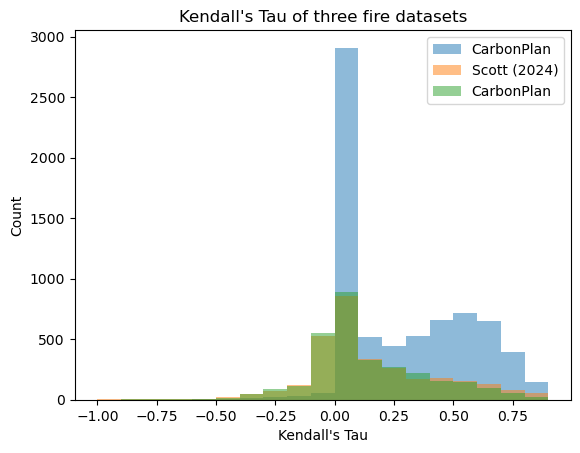

In [15]:
plt.hist(
    tract_performance_stats['CarbonPlan - Scott (2024) tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='CarbonPlan',
    alpha=0.5,
)
plt.hist(
    tract_performance_stats['Scott (2024) - CAL FIRE tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='Scott (2024)',
    alpha=0.5,
)
plt.hist(
    tract_performance_stats['CarbonPlan - CAL FIRE tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='CarbonPlan',
    alpha=0.5,
)

plt.legend()
plt.xlabel("Kendall's Tau")
plt.ylabel('Count')
plt.title("Kendall's Tau of three fire datasets")

In [16]:
variable = 'tau_c'
for ds1_name, ds2_name in combinations(ds_name_dict.keys(), 2):
    print(
        f'{ds1_name} - {ds2_name} {variable} : {tract_performance_stats[f"{ds1_name} - {ds2_name} {variable}"].mean()}'
    )

CarbonPlan - Scott (2024) tau_c : 0.27634431489440514
CarbonPlan - CAL FIRE tau_c : 0.13388645697664414
Scott (2024) - CAL FIRE tau_c : 0.15728040975275673


Plotting the data across the state we see areas of higher concordance tend to cluster in smaller tracts in more developed areas.

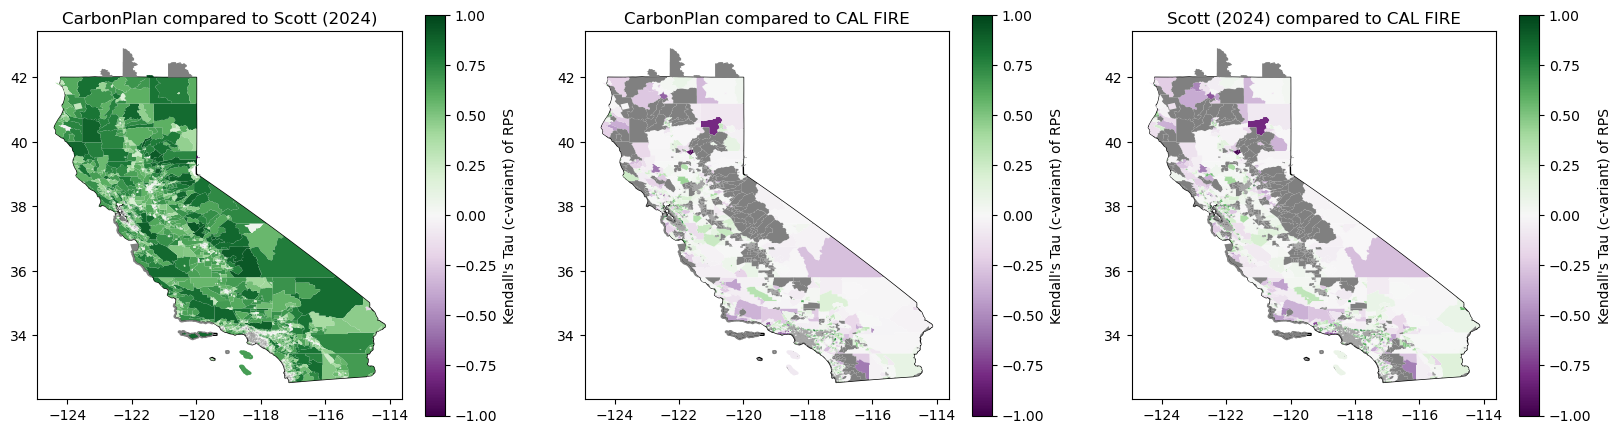

In [17]:
for variable in ['tau_c']:
    fig, axarr = plt.subplots(ncols=3, figsize=(20, 8))
    for i, (ds1_name, ds2_name) in enumerate(combinations(ds_name_dict.keys(), 2)):
        ca.plot(ax=axarr[i], color='white', edgecolor='black')
        ax = tract_performance_stats.plot(
            ax=axarr[i],
            column=f'{ds1_name} - {ds2_name} {variable}',
            vmin=var_lims[variable][0],
            vmax=var_lims[variable][1],
            legend=True,
            cmap=cmaps[variable],
            legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
        )
        tract_performance_stats[
            tract_performance_stats[f'{ds1_name} - {ds2_name} {variable}'].isnull()
        ].plot(ax=axarr[i], color='grey')
        axarr[i].set_title(f'{ds1_name} compared to {ds2_name}')